# Introduction:

This notebook introduces the DensityEstimate class. This class uses the outputs of the Lanczos algorithm to calculate the eigenvalue density (and functions of the density). 

This class requires the results of Lanczos iterations on the Hessian as inputs. In particular, we assume that for every checkpoint, the Lanczos output is saved in a separate folder in the directory. The file reader of the class assumes the folders use the naming convention 
<h5><center>(experiment name) + '.' + 'checkpoint\_' + (checkpoint number) + '.' + 'draw_' + (draw number) + '.' + (a random number). </center></h5>


Inside each folder, the output of the Lanczos iterations should be saved. This output includes the tridiagonal matrix outputed by Lanczos algorithm in addition to the Lanczos vectors. 

If the output is generated via LanczosExperiment class, various statistics of the model are also saved in the folder. These statistics are (full-batch) loss and gradient and also model parameters. These statistics should be pickled in the folder as 'stats.pkl'.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import cPickle as pickle

In [2]:
class DensityEstimate(object):
    """ This class provides the required functionalities for estimating the eigenvalue density
    from the output of LanczosExperiment.
    
    Attributes:
        num_param: Dimension of the Hessian (number of parameters in the model).
        num_lanczos: Number of Lanczos iterations performed on the Hessian.
        num_draws: Number of independent draws in the input.
        num_ckpt: Number of checkpoints present in the directory.
        ckpts: A list of the checkpoint numbers.
        jacobi: An array of the shape (num_lanczos, num_lanczos, num_draws, num_ckpt) where the
                input tridiagonal matrices are stored.        
        nodes: An array of shape (num_draws, num_lanczos, num_ckpt) corresponding to the nodes of
               the Gaussian quadrature.
        weights: An array of shape (num_draws, num_lanczos, num_ckpt) corresponding to the weights of
               the Gaussian quadrature.
        weightv: An array of shape (num_params, num_ckpt) holding the vectorized weights of the model
                at each checkpoint.
        gradv: An array of shape (num_params, num_ckpt) holding the vectorized gradient of the model
                at each checkpoint.
        grids: The grid used for the evaluation of the density. An array of the shape (grid_len, num_ckpt).
        density: The estimated density at the grid points. An array of the shape (grid_len, num_ckpt).
        """

    def __init__(self, directory, name, grid_len=500):
        """The constructor for the density estimation object.
        
        Arguments:
            directory: The directory in which the Lanczos outputs are saved.
            name: The name of the experiment. We assume the name uniquely identifies the the given experiment.            
            grid_len: The number of points used for discretizing the x-axis of the density plots.
        """
        # Defining the scalar parameters.
        self.num_param = None
        self.num_lanczos = None
        self.num_draws = None
        self.num_ckpt = None
        self.grid_len = grid_len 

        self._dir = directory
        self._attempt_list = [name]
        self.ckpts = None
        
        # Defining the matrix parameters.
        self.jacobi = None        
        self.nodes = None
        self.weights = None
        

        # Read the directory and register the checkpoints
        self._list_ckpts()
        print('Total Number of Checkpoints: %d'%(self.num_ckpt))
        print('Loading Checkpoints ...')
        for i in range(self.num_ckpt):
            self._read_ckpt(str(self.ckpts[i]), i)
        print('Loading Checkpoints Done.')
        if self.num_param is not None:
            self.weightv = np.zeros((self.num_param, self.num_ckpt))
            self.gradv = np.zeros((self.num_param, self.num_ckpt))
            self._vectorize()
        self.grids = np.zeros((self.grid_len, self.num_ckpt))
        self.density = np.zeros((self.grid_len, self.num_ckpt))    
    
    def _list_ckpts(self):
        """This function scans the directory given to the class and records the
        checkpoints and number of draws.
        """        
        ckpts_list = os.listdir(self._dir)
        temp = [f for f in ckpts_list if self._validity_check(self._attempt_list, f)]    
        self.ckpts = [int(f.split('.')[-3].split('_')[-1]) for f in temp]
        self.ckpts = list(set(self.ckpts))
        self.ckpts = np.sort(self.ckpts)       
        self.num_ckpt = len(self.ckpts)
        print('Following checkpoints are identified: ')
        print(self.num_ckpt)
        tau = [int(f.split('.')[-2].split('_')[-1]) for f in temp]
        self.num_draws = max(tau)
        print('Number of draws: %d'%(self.num_draws))
        self.loss = np.zeros((self.num_ckpt,))
        self.weight_grad = [None for _ in range(self.num_ckpt)]
        self.weight_size = None
  
    def _read_ckpt(self, ckpt_num, ind):
        """This function reads the tridiagonal matrices coming from the Lanczos iteration. 
        
        Arguments:
            ckpt_num: String format of the checkpoint number.
            ind: The index corresponding to the checkpoint number in the array of all checkpoint numbers.
        """        
        ckpts_list = os.listdir(self._dir)
        request_folder = self._attempt_list + ['checkpoint_' + ckpt_num]
        
        temp = [f for f in ckpts_list if self._validity_check(request_folder, f)]        
        temp.sort()
        read_stats = False        
        for i in range(len(temp)):
            PATH = os.path.join(self._dir, temp[i])            
            PATH0 = os.path.join(PATH, 'tridiag_1.npy')             
            try:                
                tridiag = np.squeeze(np.load(PATH0))
            except:
                print('Error Reading: ' + temp[i])
                return None, None, None, None

            if self.num_lanczos is None:
                self.num_lanczos = tridiag.shape[0]                
                self.jacobi = np.zeros((self.num_lanczos, self.num_lanczos, self.num_draws, self.num_ckpt))
                self.nodes = np.zeros((self.num_draws, self.num_lanczos, self.num_ckpt))
                self.weights = np.zeros((self.num_draws, self.num_lanczos, self.num_ckpt))
                self.jacobi[:] = np.nan
                self.nodes[:] = np.nan
                self.weights[:] = np.nan

            self.jacobi[:, :, i, ind] = tridiag 
            # Calculating the node / weights from Jacobi matrices. 
            nodes, evecs = np.linalg.eigh(tridiag)
            index = np.argsort(nodes)      
            nodes = nodes[index]
            evecs = evecs[:, index]

            self.nodes[i, :, ind] = nodes
            self.weights[i, :, ind] = evecs[0, :] ** 2

            # Reading Optional Stats
            if not read_stats:
                PATH2 = os.path.join(PATH, 'stats.pkl')
                try:                    
                    with open(PATH2, 'rb') as f:
                        self.weight_grad[ind], self.loss[ind] = pickle.load(f)
                        read_stats = True
                        self._configure_dims(self.weight_grad[ind])
                except:
                    print('Reading from ' + temp[i] + ' was unsuccessful')
            if not read_stats:
                print('No stats for checkpoint ' + ckpt_num)  

    def _configure_dims(self, weight_dict):
        if self.num_param is None:
            self.weight_size = np.array([np.prod(weight_dict[zeta][0].shape) for zeta in weight_dict.keys()])
        self.num_param = np.sum(self.weight_size)
        self.var_names = [name for name in weight_dict.keys()]
    
    def _vectorize(self):
        """ This function converts weights and gradients of the checkpoints from a list of tensors format
        to vector format. 
        """
        for i in range(self.num_ckpt):
            if self.weight_grad[i] is not None:
                temp = np.concatenate([self.weight_grad[i][x][0].flatten() for x in self.var_names])
                self.weightv[:, i] = temp
                temp = np.concatenate([self.weight_grad[i][x][1].flatten() for x in self.var_names])
                self.gradv[:, i] = temp
                   
    def _validity_check(self, list1, string):
        """ This function tests to see if all the elements of list1 are present in the input string.
        """
        for f in list1:
            if not f in string:
                return False
        return True

    def compute_density(self, sigma_squared=None):
        """ This function estimates the smoothed density as described in the paper. sigma_squared is
        the width parameter of the Gaussian kernel used for smoothing. For a distribution supported on [-1, 1],
        with 90 Lanczos iterations, we observe that sigma_squared=1e-5 is a reasonable choice.
        """
        lambda_max = np.nanmean(np.max(self.nodes, axis=1), axis=0)
        lambda_min = np.nanmean(np.min(self.nodes, axis=1), axis=0)    
        for i in range(self.num_ckpt):
            se = lambda_min[i] - 10 ** -2
            le = lambda_max[i] + 10 ** -2
            self.grids[:, i] = np.linspace(se, le, num=self.grid_len)
            if sigma_squared is None:
                sigma = [10 ** -5 * max([1, (le - se)])]
            else:
                sigma = [sigma_squared * max([1, (le - se)])]
            self._evaluate_function(i, sigma)
            norm_fact = np.sum(self.density[:, i]) * (self.grids[1, i] - self.grids[0, i])
            self.density[:, i] = self.density[:, i] / norm_fact
      
    def _evaluate_function(self, index, hyper_param):
        """ This function uses the smoothing kernel and the computed quadrature
        nodes and weights to calculate the smoothed density on the density_grid.

        Arguments:
          index: the index of the checkpoint number used to compute the density.
          hyper_param: a list of the hyper parameters of the kernel.

        Returns:
          a numpy array of the same size as density_grid correspondingto the estimated
          density.
        """    
        density = np.zeros((self.num_draws, self.grid_len))
        density[:] = np.nan
        for i in range(self.num_draws):
            if np.isnan(self.nodes[i, 0, index]):
                density[i, :] = np.nan
                print('Draw %d, of Checkpoint %d is NaN'%(i, self.ckpts[index]))
            else:
                for j in range(self.grid_len):
                    x = self.grids[j, index]
                    vals = self._kernel(self.nodes[i, :, index], x, hyper_param)
                    density[i, j] = np.sum(vals * self.weights[i, :, index])
        self.density[:, index] = np.nanmean(density, axis=0)
  
    def _kernel(self, x, x0, sigma):
        """ This function computes the Gaussian kernel for 
        C exp(-(x - x0) ^2 /(2 * sigma)) where C is the appropriate normalization.
        sigma should be a list of length 1. Either x0 or x should be a scalar. Only 
        one of the x or x0 can be a numpy array. 

        Returns: a numpy array corresponding to C exp(-(x - x0) ^2 /(2 * sigma))."""
        sigma = sigma[0]
        coeff = 1.0 / np.sqrt(2 * math.pi * sigma)
        val = -(x0 - x) ** 2
        val = val / (2.0 * sigma)
        val = np.exp(val)
        return coeff * val
    
    def _median(self, den, grid):
        """ This function computes the median of the distribution defined by the input density and grid.
        """
        ind = np.argsort(grid)
        den = den[ind]
        grid = grid[ind]
        den = den / np.sum(den)
        temp = np.cumsum(den)
        index = np.argmin(np.abs(temp - 0.5))
        return grid[index]
  
    def _quantile(self, den, val, q):
        """ q is the quantile we want to calculate. It should be a number between
        0 and 1.
        """
        ind = np.argsort(val)
        den = den[ind]
        val = val[ind]
        den = den / np.sum(den)
        temp = np.cumsum(den)
        index = np.argmin(np.abs(temp - q))
        return val[index]
    
    def sum_stats(self):
        """This function produces some summary statistics of the estimated distribution. Computed summary
            statistics are: mean, mean of the absolute value (ell_1), median, standard deviation, and spectral range.
        """
        self.mean = np.zeros((self.num_ckpt,))
        self.ell_1 = np.zeros((self.num_ckpt,))
        self.median = np.zeros((self.num_ckpt,))
        self.std = np.zeros((self.num_ckpt,))        
        self.range = np.zeros((self.num_ckpt,))
        for i in range(self.num_ckpt):
            norm = np.sum(self.density[:, i])
            self.mean[i] = np.sum(self.density[:, i] * self.grids[:, i]) / norm
            self.ell_1[i] = np.sum(self.density[:, i] * np.abs(self.grids[:, i])) / norm
            variance = np.sum(self.density[:, i] * (self.grids[:, i] ** 2)) / norm - self.mean[i] ** 2
            self.std[i] = variance ** 0.5
            self.median[i] = self._median(self.density[:, i], self.grids[:, i])
            temp = np.abs(self.grids[:, i] - self.median[i])            
            self.range[i] = self.nodes[0, -1, i] - self.nodes[0, 0, i]

  
    def step_function(self, index, thresh):
        """ This function computes the CDF of the estimated distribution at a specified threshold. 
        
        Arguments:
            index: The checkpoint index.
            thresh: The point where the CDF is evaluated.
        """
        ind = np.argmin(np.abs(self.grids[:, index] - thresh))
        tau = self.density[:, index]
        fraction = np.sum(tau[:ind]) / np.sum(tau)  
        return fraction
  
    def eigen_vecs(self, index, maxr=1):
        """This function calculates the Ritz-vectors associated with the given checkpoint index. 
        For large enough Lanczos iterations, the extreme eigenvectors match the Ritz vectors. 
        
        Arguments:
            index: Index of the checkpoint. An integer between 0 and num_ckpt
            maxr: The number of draws for which we want to compute the Ritz vectors. As this
                computation is rather heavy, we usually compute the Ritz vectors only for one draw.
        
        Returns:
            output: A numpy array of shape (num_param, num_lanczos, maxr) corresponding
                    to the Ritz vectors. output[:, -1, i] corresponds to the most dominant
                    eigenvector while output[:, 0, i] corresponds to the eigenvector with 
                    the smallest eigenvalue. 
        """
        ckpts_list = os.listdir(self._dir)        
        request_folder = self._attempt_list + ['checkpoint_' + ckpt_num]
        temp = [f for f in ckpts_list if self._validity_check(request_folder, f)]
        temp.sort()
        
        output = None
        num_instances = min([len(temp), maxr]) 
        for i in range(num_instances):
            PATH = os.path.join(self._dir, temp[i])        
            PATH1 = os.path.join(PATH, 'lanczos_vec_1.npy')
            try:
                vecs = np.squeeze(np.load(PATH1))                
            except:
                print('Error Reading: ' + temp[i])
                return None
            if self.num_param is None:
                self.num_param = vecs.shape[0]
            if output is None:
                output = np.zeros((self.num_param, self.num_lanczos, self.num_instances))
                output[:] = np.nan

            tridiag = self.jacobi[:, :, i, index]
            nodes, evecs = np.linalg.eigh(tridiag)      
            idx = np.argsort(nodes)      
            evecs = evecs[:, idx]      
            output[:, :, i] = np.dot(vecs, evecs)      
        return output

## Tests:

We consider a simple model of the form $$L(\theta, \zeta) = \frac{1}{2} \theta^T H \theta + a^T \zeta$$ with $H \in R^{n \times n}$ being diagonal and $\theta \in R^n$ and $\zeta \in R^{\frac{n}{2}}$. $a_i \sim \mathcal{N}(0, 1)$ are fixed constants and $\theta_i = 1$ and $\zeta_i = 2$.

In [4]:
def lanczos_algo(vec, lanczos_steps, reorthogonalize=True):    
    assert len(vec.shape) == 1
    d = len(vec)
    m = lanczos_steps
    # lanczos vectors
    V = np.zeros((d, m))
    # tridiagonal 
    T = np.zeros((m, m))
    
    x = np.random.normal(size=(d,))
    q = x / np.linalg.norm(x)
    V[:, 0] = q
    r = vec * q
    alpha = np.sum(r * q)
    T[0, 0] = alpha
    r = r - alpha * q
    beta = np.linalg.norm(r)
    T[0, 1] = beta
    T[1, 0] = beta
    for i in range(1, m):
        v = np.copy(q)
        q = r / beta
        V[:, i] = q
        r = vec * q - beta * v
        alpha = np.sum(q * r)        
        T[i, i] = alpha
        r = r - alpha * q #Reorthogonal
        if reorthogonalize:
            r = r - np.dot(V, np.dot(V.T, r))
        beta = np.linalg.norm(r)
        if i < m - 1:
            T[i, i + 1] = beta
            T[i + 1, i] = beta
        if beta < 1e-6:
            raise Exception('Rank Deficiency Encountered.')        
    return (T, V)

In [42]:
dim = 30000
np.random.seed(2019)
random_tilt = np.random.exponential(scale=1.0)
eigens = np.random.normal(size=(dim,)) - random_tilt
eigens = np.sort(eigens)
for i in range(5):
    eigens[i] = -7 - i
    eigens[-i - 1] = 15 - i
theta = np.ones((dim,))
zeta = np.ones((dim / 2,)) * 2.0
a = np.random.normal(size=(dim / 2,))
hessian_eigens = np.concatenate([eigens, np.zeros((dim / 2,))])

In [43]:
loss = np.sum(eigens) * 0.5 + np.sum(a) * 2
weight_grad = {'zeta': (zeta, a), 'theta': (theta, eigens)}

In [44]:
for i in range(10):
    draw = i + 1
    rv = np.random.randint(0, 10000)
    dirname = ['testExperiment', 'checkpoint_0', 'draw_%d'%(draw), '%d'%(rv)]    
    dirname=".".join(dirname)
    val = os.makedirs('./hessianExperiments/' + dirname)    
    
    m = 70 # Number of lanczos iterations
    T, V = lanczos_algo(hessian_eigens, m, True)
    np.save('./hessianExperiments/' + dirname + '/tridiag_1', T)
    np.save('./hessianExperiments/' + dirname + '/lanczos_vec_1', V) 
    
    filehandler = open('./hessianExperiments/' + dirname + '/stats.pkl', "wb")
    pickle.dump([weight_grad, loss], filehandler)

In [45]:
density_object = DensityEstimate('./hessianExperiments/', 'testExperiment', 700)

Following checkpoints are identified: 
1
Number of draws: 10
Total Number of Checkpoints: 1
Loading Checkpoints ...
Loading Checkpoints Done.


In [46]:
density_object.compute_density(sigma_squared=2e-4)

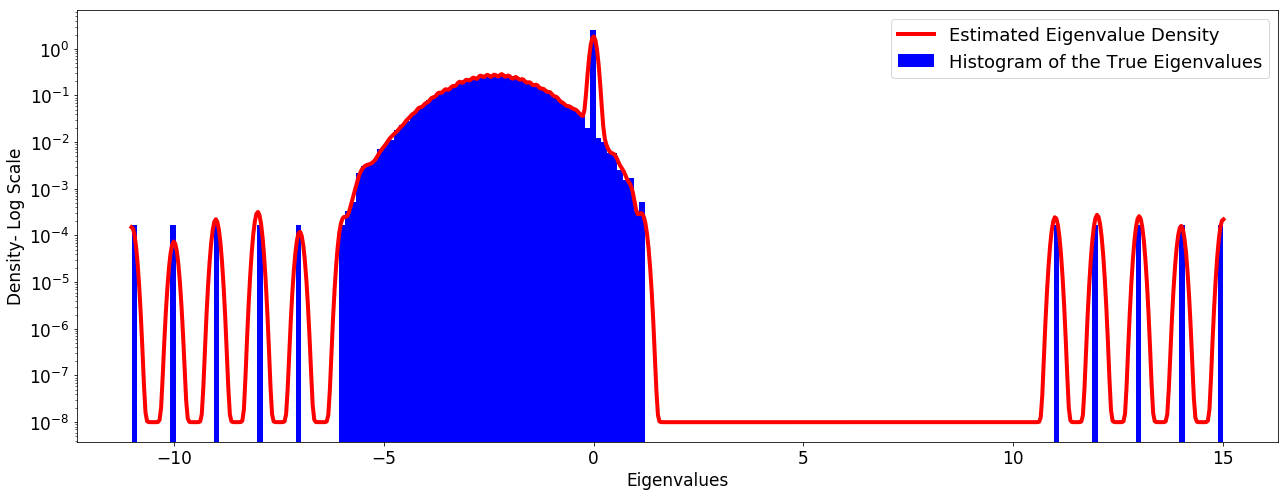

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(18, 7))
ax.plot(density_object.grids, density_object.density + 1e-8, linewidth=4, color='r', label='Estimated Eigenvalue Density')
ax.hist(hessian_eigens, bins=200, density=True, color='b', label='Histogram of the True Eigenvalues')
ax.set_yscale('log')
ax.set_ylabel('Density- Log Scale')
ax.set_xlabel('Eigenvalues')
for temp_ax in [ax]:
    for item in ([temp_ax.title, temp_ax.xaxis.label, temp_ax.yaxis.label] +
                 temp_ax.get_xticklabels() + temp_ax.get_yticklabels()):
        item.set_fontsize(17)
    temp_ax.legend(loc=0, fontsize=18)
fig.tight_layout()
plt.show()

In [51]:
density_object.sum_stats()

### Summary Statistics Comparison:
Let's compare the summary statistics of the exact eigenvalues with the statistics of the estimated density.

In [52]:
import pandas as pd

In [53]:
summary_stat = np.zeros((5, 2))
summary_stat[0, 0] = np.mean(hessian_eigens)
summary_stat[0, 1] = density_object.mean
summary_stat[1, 0] = np.median(hessian_eigens)
summary_stat[1, 1] = density_object.median
summary_stat[2, 0] = np.std(hessian_eigens)
summary_stat[2, 1] = density_object.std
summary_stat[3, 0] = np.mean(np.abs(hessian_eigens))
summary_stat[3, 1] = density_object.ell_1
summary_stat[4, 0] = np.max(hessian_eigens) - np.min(hessian_eigens)
summary_stat[4, 1] = density_object.range
summary_stat = pd.DataFrame(summary_stat, columns=['True Distribution', 'Estimated Distribution'],
                            index=['Mean', 'Median', 'Standard Deviation', 'Mean Absolute Value', 'Spectral Range'])

In [54]:
print(summary_stat)

                     True Distribution  Estimated Distribution
Mean                         -1.561000               -1.564578
Median                       -1.674432               -1.703848
Standard Deviation            1.384709                1.392025
Mean Absolute Value           1.567618                1.592517
Spectral Range               26.000000               26.000000


### Testing the Quantile Function:

We compute the smallest $x$ such that $P(\lambda \leq x) = p$ for $p \in \{0, \frac{1}{100}, \dots, 1\}$ once using the exact Hessian eigenvalue density and once using the estimate density. The results should be close.

In [55]:
probs = np.linspace(0, 1, num=100)
vals = np.zeros((100, 2))
emp_den = np.array([1.0 / len(hessian_eigens)] * len(hessian_eigens))
for i in range(100):
    vals[i, 0] = density_object._quantile(emp_den, hessian_eigens, probs[i])
    vals[i, 1] = density_object._quantile(density_object.density[:, 0], density_object.grids[:, 0], probs[i])

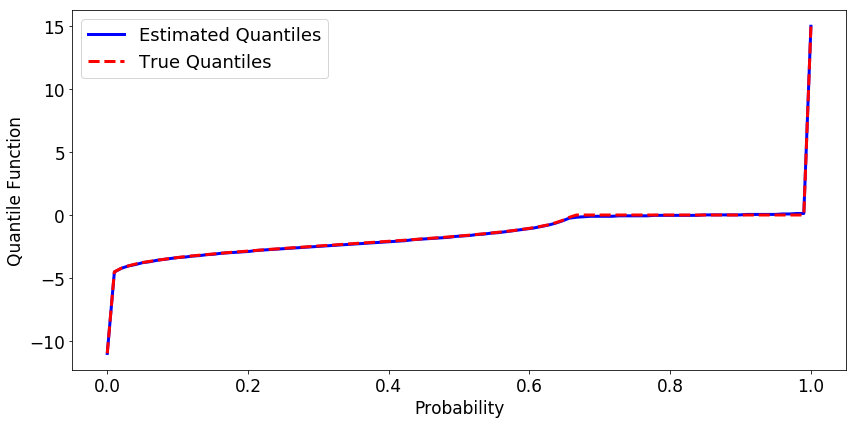

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(probs, vals[:, 1], 'b', linewidth=3, label='Estimated Quantiles')
ax.plot(probs, vals[:, 0], 'r--', linewidth=3, label='True Quantiles')
ax.set_xlabel('Probability')
ax.set_ylabel('Quantile Function')
for temp_ax in [ax]:
    for item in ([temp_ax.title, temp_ax.xaxis.label, temp_ax.yaxis.label] +
                 temp_ax.get_xticklabels() + temp_ax.get_yticklabels()):
        item.set_fontsize(17)
    temp_ax.legend(loc=0, fontsize=18)
fig.tight_layout()
plt.show()